# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
# Descarga de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Carga de los datos y convertimiento de la columna de fecha
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
# Nos aseguramos que el indice haya quedado cronologicamente
print(data.index.is_monotonic)

True


In [4]:
# Ver informacion de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
# Remuestreo de los datos por hora
hourly_data = data.resample('H').sum()

# Mostrar las primeras filas del remuestreo
hourly_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Análisis

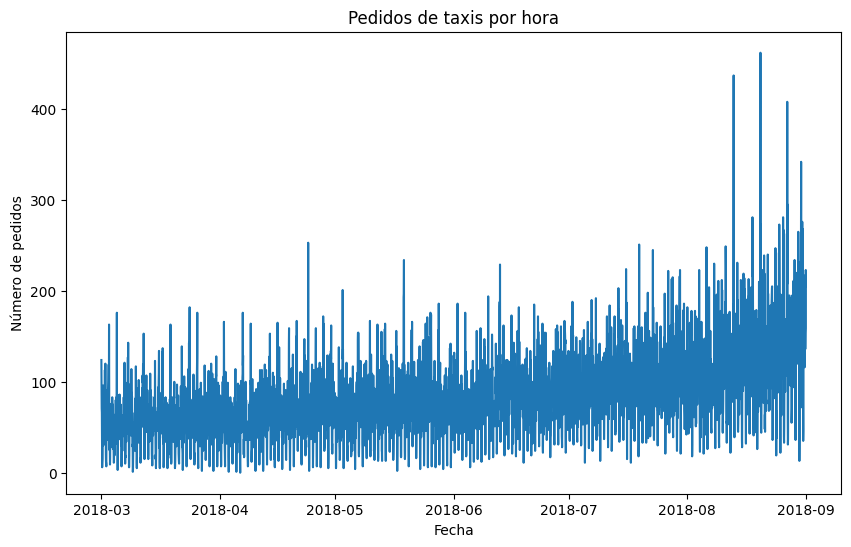

In [7]:
# Visualizaciòn de los datos de pedidos por hora
plt.figure(figsize=(10,6))
plt.plot(hourly_data['num_orders'])
plt.title('Pedidos de taxis por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.show()

A medida que avanzan los meses, se observa un aumento general en la cantidad de pedidos de taxis, lo que indica un crecimiento sostenido en la demanda de taxis, teniendo los picos mas altos entre los meses 8 y 9.

In [8]:
# Estadísticas descriptivas de los datos
hourly_data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


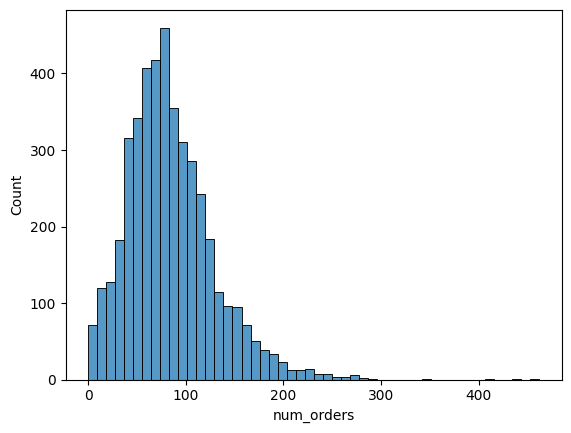

In [9]:
# Visualizaciòn de la distribucion de las datos
sns.histplot(hourly_data['num_orders'], bins=50)
plt.show()

La mayoría de los datos se concentran entre los 0 y 150 pedidos por hora, con un pico alrededor de los 100 pedidos. Esto indica que, en la mayoría de las horas, la cantidad de pedidos de taxis se encuentra en ese rango. Hay algunos casos en los que el número de pedidos es significativamente mayor (más de 200, hasta 400), estos son casos menos comunes. Finalmente, la mayor demanda se encuentra entre los 50 y 150 pedidos.

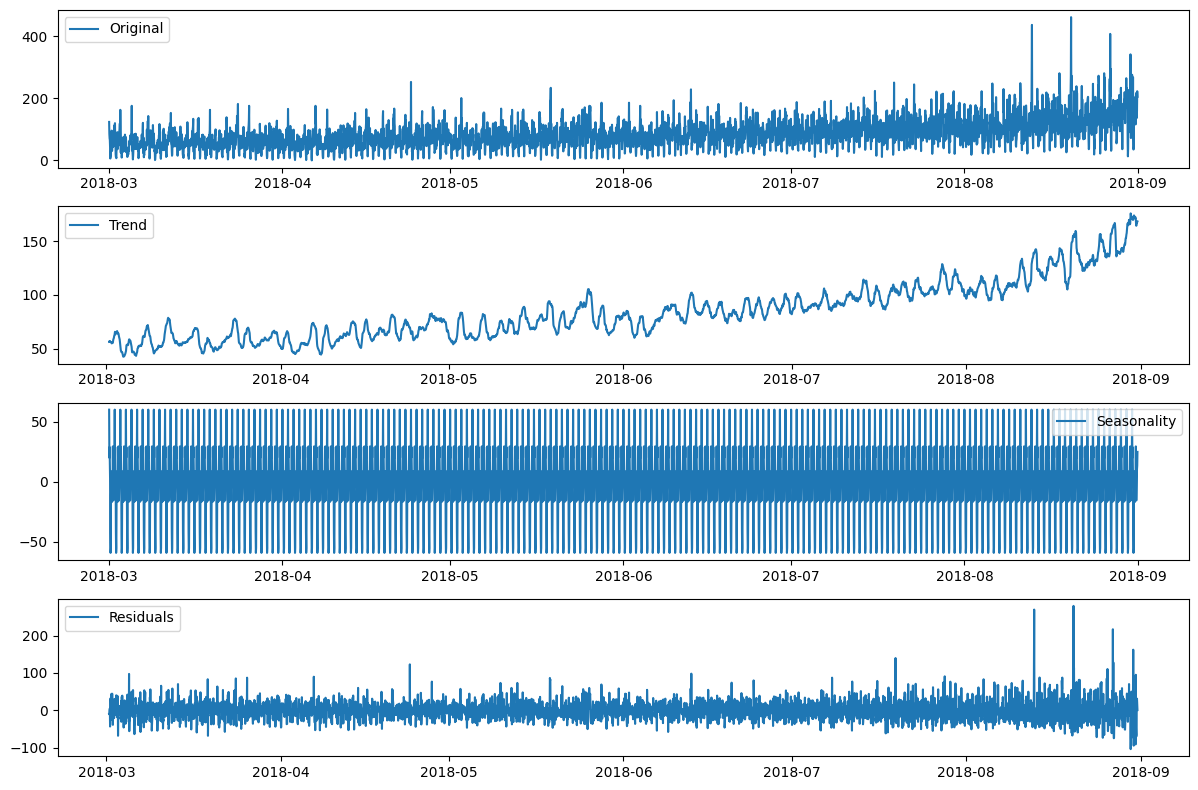

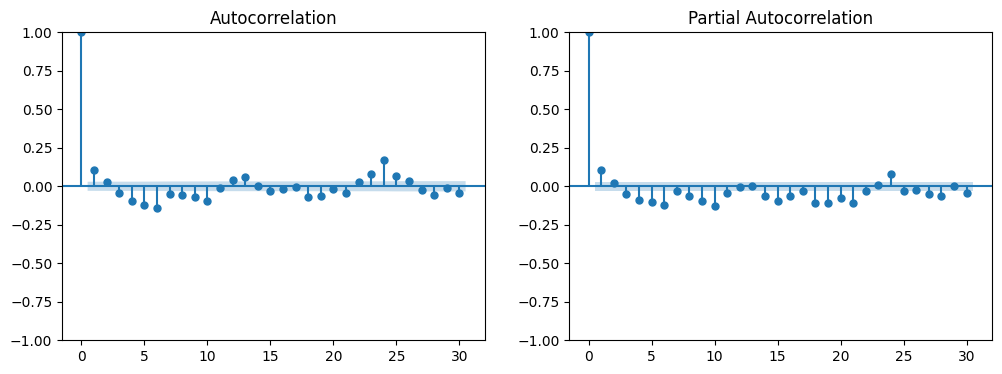

In [10]:
decomposition = seasonal_decompose(hourly_data['num_orders'], model='additive')

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(hourly_data['num_orders'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# You can analyze the autocorrelation of the residuals using ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_acf(decomposition.resid.dropna(), lags=30, ax=plt.gca())
plt.subplot(122)
plot_pacf(decomposition.resid.dropna(), lags=30, ax=plt.gca())
plt.show()

## Formación

In [11]:
# Creaciòn de nuevas características
def make_features(hourly_data, max_lag, rolling_mean_size):
    hourly_data['year'] = hourly_data.index.year
    hourly_data['month'] = hourly_data.index.month
    hourly_data['day'] = hourly_data.index.day
    hourly_data['dayofweek'] = hourly_data.index.dayofweek

    for lag in range(1, max_lag + 1):
        hourly_data['lag_{}'.format(lag)] = hourly_data['num_orders'].shift(lag)

    hourly_data['rolling_mean'] = (
        hourly_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )



make_features(data, 6, 10)

data = data.dropna()

train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [12]:
print(train.shape)
print(test.shape)

print(features_train.shape)
print(target_train.shape)
print(target_test.shape)

(21453, 12)
(2649, 12)
(21453, 11)
(21453,)
(2649,)


## Prueba

In [13]:
# Entrenamiento modelo de Regresión Lineal
model = LinearRegression()
model.fit(features_train, target_train)

# Predicciones
target_pred_lr = model.predict(features_test)

print('RECM Regresion Lineal:', mean_squared_error(target_test, target_pred_lr, squared=False))

RECM Regresion Lineal: 8.461172475968533


In [14]:
# Entrenamiento modelo Árbol de Decisión
tree_model = DecisionTreeRegressor(max_depth=10, random_state=12345)
tree_model.fit(features_train, target_train)

# Predicciones
target_pred_tree = tree_model.predict(features_test)

print('RECM Árbol de Decisión:', mean_squared_error(target_test, target_pred_tree, squared=False))

RECM Árbol de Decisión: 10.894633245819126


In [15]:
# Entrenamiento Random Forest
forest_model = RandomForestRegressor(n_estimators=150, max_depth=6, random_state=12345)
forest_model.fit(features_train, target_train)

# Predicciones
target_pred_forest = forest_model.predict(features_test)
print('RECM Random Forest:', mean_squared_error(target_test, target_pred_forest, squared=False))

RECM Random Forest: 9.332678308590339


In [16]:
# Entrenamiento del modelo de LightGBM
train_data = lgb.Dataset(features_train, label=target_train)
test_data = lgb.Dataset(features_test, label=target_test)
params = {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 31, 'force_col_wise':True}
lgb_model = lgb.train(params, train_data, num_boost_round=100)

# Predicciòn y evaluaciòn
target_pred_lgb = lgb_model.predict(features_test)

print('RECM LightGBM:', mean_squared_error(target_test, target_pred_lgb, squared=False))

[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 21453, number of used features: 10
[LightGBM] [Info] Start training from score 12.459050
RECM LightGBM: 9.371322398761416


In [17]:
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=12345)
gb_model.fit(features_train, target_train)

#predicciones 
target_pred_gb = gb_model.predict(features_test)

print('RECM - Gradient Boosting:', mean_squared_error(target_test, target_pred_gb, squared=False))

RECM - Gradient Boosting: 9.574394841107274


## Conclusiòn


El RECM obtenido del modelo de Regresion Lineal es el mejor, 8.46. Ahora bien, por el tema de la variabilidad de los datos en el tiempo, sugerimos el Random Forest, que fue el de segundo mejor resultado, 9.33, y puede funcionar mejor en la medida que los datos muestren inconsistencia.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48